# Vedant - Example

How to run contacts using the brahe library, with some additional functions in this repository!

First, make sure to install the brahe library:

```bash
pip install git+https://github.com/duncaneddy/brahe.git@master matplotlib ipympl cartopy
```

## Setup Imports

(not relevant to repo, can skip) 

Adding module path to run correctly in examples folder

In [1]:
import sys
import os

# Add the path to the folder containing the module
module_path = os.path.abspath(os.path.join('..'))
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)

/Users/gracekim/Documents/School_Everything_and_LEARNING/Stanford/Githubs/loc-gsopt/src


## Imports & Downloading latest Earth Orientation Data

In [26]:
from common.sat_gen import make_tle
from common.station_gen import teleport_json
from common.utils import load_earth_data, compute_all_gaps_contacts

# Brahe Imports
import brahe as bh
import brahe.data_models as bdm
import brahe.access.access as ba
import numpy as np 
%matplotlib inline

import matplotlib.pyplot as plt

# Setup info
load_earth_data('data/iau2000A_finals_ab.txt')

Loading the latest Earth Orientation Data


## Generate Satellites Using TLEs

In [3]:
##### Trying to generate a satellite just through tles ######

# Create a TLE
epc0 = bh.Epoch(2024, 5, 20, 0, 0, 0) # This is the epoch of the orbital elements
alt  = 550 # Altitude in km
ecc  = 0.01 # Eccentricity - Generally don't want it to be 0, so give it a small value 0.0001 to 0.01
inc  = 53 # Inclination in degrees
raan = 15 # Right Ascension of the Ascending Node in degrees
argp = 30 # Argument of Perigee in degrees
M    = 45 # Mean Anomaly in degrees
norad_id = 99999 # NORAD ID of the satellite - This is just a placeholder, but we need a number.

tle = make_tle(epc0, alt, ecc, inc, raan, argp, M, norad_id=norad_id)

print(f'Our TLE looks like:\n {tle.line1}\n {tle.line2}\n')

sat1 = bdm.Spacecraft(
    id=99999, # Might need to change this at one point
    name="Sat1",
    line1=tle.line1,
    line2=tle.line2,
)

Our TLE looks like:
 1 99999U          24141.00000000  .00000000  00000-0  00000-0 0    00
 2 99999  53.0000  15.0000 0100000  30.0000  45.0000 15.05490874    07



## Load Ground Station Locations and Compute Contacts

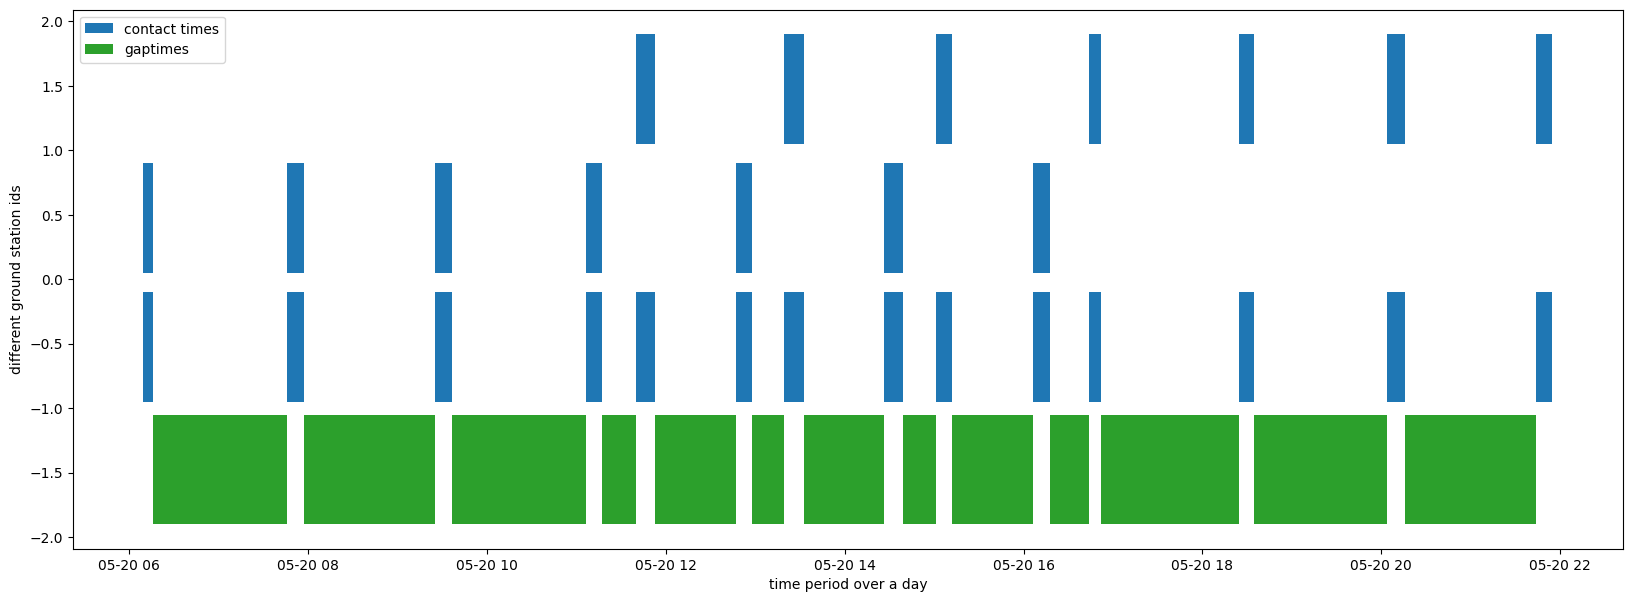

In [ ]:
fig, ax = fig, ax =  plt.subplots(figsize=(20,7))

# Ground station Locations
stations = teleport_json('data/teleport_locations.json')

# Computing Contacts for only one day
epc1 = epc0 + 86400 # seconds in a day

contacts_all = []

######################## Plotting specific! ####################

# going through computing contacts for all stations and all 
for station,id in zip(stations[0:2],range(len(stations[0:2]))):
    contacts = ba.find_location_accesses(sat1,station,epc0,epc1)
    for contact in contacts:
        contacts_all.append(contact)
    ax.broken_barh([(contacts[i].t_start,contacts[i].t_end-contacts[i].t_start) for i in range(len(contacts))], (id+0.05, 0.85),facecolors='tab:blue')

ax.broken_barh([(contacts_all[i].t_start,contacts_all[i].t_end-contacts_all[i].t_start) for i in range(len(contacts_all))], (-0.95, 0.85),facecolors='tab:blue', label = "contact times")

sorted_contacts = sorted(contacts_all, key=lambda t: t.t_start)
all_gap_times = []

current_t_end = sorted_contacts[0].t_end
for contact in sorted_contacts:
    if current_t_end < contact.t_end and current_t_end > contact.t_start:
        current_t_end = contact.t_end
    if current_t_end < contact.t_start:
        all_gap_times.append((current_t_end,contact.t_start))
        current_t_end = contact.t_end

ax.broken_barh([(all_gap_times[i][0],all_gap_times[i][1]-all_gap_times[i][0]) for i in range(len(all_gap_times))], (-1.9, 0.85),facecolors='tab:green',label = "gaptimes")

plt.ylabel("different ground station ids")
plt.xlabel("time period over a day")
plt.legend()
plt.show()

######################## Plotting specific! ####################



### Just to see the gap times:

In [23]:
_, _, gaps_seconds = compute_all_gaps_contacts([sat1], stations[0:5] ,epc0, epc1, False)


In [27]:
np.mean(gaps_seconds)

11813.102626257143